## Import packages and load datasets

In [1]:
#Import Packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Load Data
users = pd.read_csv('takehome_users.csv', encoding='latin1')
engagement = pd.read_csv('takehome_user_engagement.csv')

#### Merge datasets

In [4]:
# Join the tables on the common user identifier column
df = pd.merge(engagement, users, left_on='user_id', right_on='object_id', how='inner')

In [5]:
df.to_csv('merged_dataset.csv', index=False)

## Data Wrangling

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   time_stamp                  207917 non-null  object 
 1   user_id                     207917 non-null  int64  
 2   visited                     207917 non-null  int64  
 3   object_id                   207917 non-null  int64  
 4   creation_time               207917 non-null  object 
 5   name                        207917 non-null  object 
 6   email                       207917 non-null  object 
 7   creation_source             207917 non-null  object 
 8   last_session_creation_time  207917 non-null  float64
 9   opted_in_to_mailing_list    207917 non-null  int64  
 10  enabled_for_marketing_drip  207917 non-null  int64  
 11  org_id                      207917 non-null  int64  
 12  invited_by_user_id          116887 non-null  float64
dtypes: float64(2),

In [8]:
# Convert date fields to date/Time type
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [9]:
df.head()

,time_stamp,user_id,visited,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2013-11-15 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,2013-11-29 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-12-09 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
4,2013-12-25 03:45:04,2,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


#### Gather some initial counts

In [12]:
# Group by 'user_id' and count occurrences of 'time_stamp' for each user
user_activity_counts = df.groupby('user_id')['time_stamp'].count().reset_index()

# Rename the count column
user_activity_counts.columns = ['user_id', 'activity_count']


# Sort the DataFrame by 'activity_count' in descending order
user_activity_counts.sort_values(by='activity_count', inplace = True, ascending=False)

# Print the resulting table
print(user_activity_counts)

      user_id  activity_count
2652     3623             606
657       906             600
1315     1811             593
5548     7590             590
5877     8068             585
...       ...             ...
3440     4699               1
3439     4698               1
3438     4697               1
3437     4696               1
8822    12000               1

[8823 rows x 2 columns]


### Create the target Variable - Adopted

In [13]:
# Step 1: Calculate the number of logins for each user per week
df['week'] = df['time_stamp'].dt.week
weekly_logins = df.groupby(['user_id', 'week']).size().reset_index(name='logins_per_week')

# Step 2: Determine the date range for the two recent months
recent_month_start = df['time_stamp'].max() - pd.DateOffset(months=2)
recent_month_end = df['time_stamp'].max()

# Step 3: Identify adopted users
adopted_users = []
for user_id in df['user_id'].unique():
    user_activity = df[df['user_id'] == user_id]
    if len(user_activity) < 3:
        continue
    
    # Check if the user logged in more than 3 times a week over the past 2 months
    recent_month_logins = user_activity[(user_activity['time_stamp'] >= recent_month_start) & (user_activity['time_stamp'] <= recent_month_end)]
    if (recent_month_logins.groupby('week').size() > 3).sum() >= 3:
        adopted_users.append(user_id)

# Step 4: Create the "adopted" column
df['adopted'] = df['user_id'].isin(adopted_users).astype(int)

# Display the DataFrame with the new "adopted" column
print(df)

                time_stamp  user_id  visited  object_id       creation_time  \
0      2014-04-22 03:53:30        1        1          1 2014-04-22 03:53:30   
1      2013-11-15 03:45:04        2        1          2 2013-11-15 03:45:04   
2      2013-11-29 03:45:04        2        1          2 2013-11-15 03:45:04   
3      2013-12-09 03:45:04        2        1          2 2013-11-15 03:45:04   
4      2013-12-25 03:45:04        2        1          2 2013-11-15 03:45:04   
...                    ...      ...      ...        ...                 ...   
207912 2013-09-06 06:14:15    11996        1      11996 2013-09-06 06:14:15   
207913 2013-01-15 18:28:37    11997        1      11997 2013-01-10 18:28:37   
207914 2014-04-27 12:45:16    11998        1      11998 2014-04-27 12:45:16   
207915 2012-06-02 11:55:59    11999        1      11999 2012-05-31 11:55:59   
207916 2014-01-26 08:57:12    12000        1      12000 2014-01-26 08:57:12   

                  name                      email  

In [15]:
df.to_csv('modelready_dataset.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

### Visualization

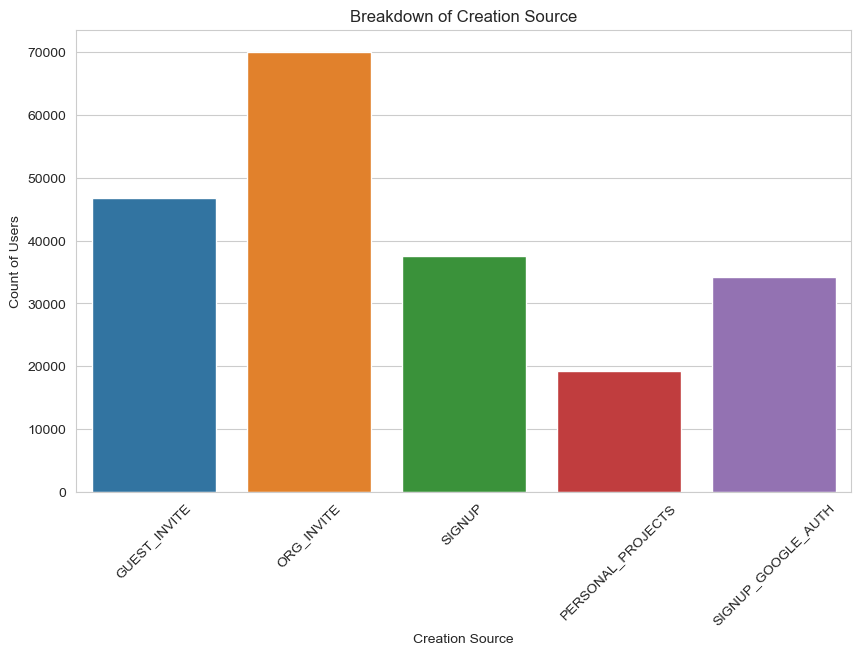

In [16]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Plotting the breakdown of creation_source
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='creation_source')
plt.title('Breakdown of Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Count of Users')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


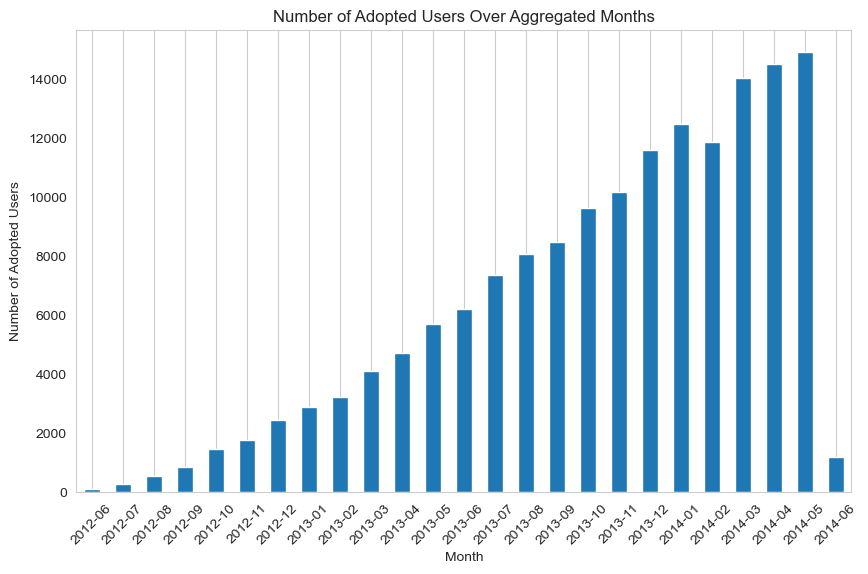

In [17]:
# Aggregate the data by month and count the number of adopted users
adopted_by_month = df[df['adopted'] == 1].groupby(df['time_stamp'].dt.to_period('M')).size()

# Plot the histogram
adopted_by_month.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Adopted Users Over Aggregated Months')
plt.xlabel('Month')
plt.ylabel('Number of Adopted Users')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


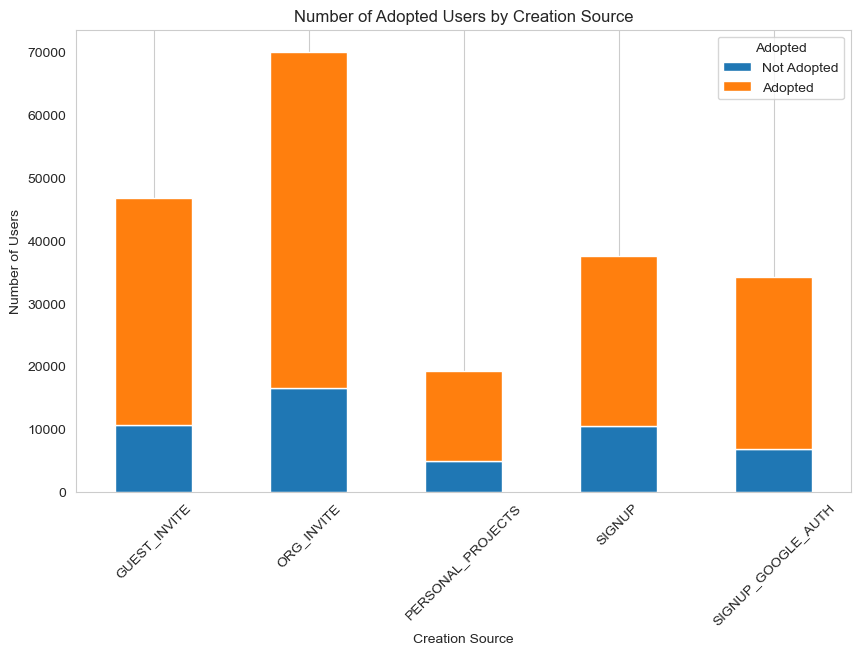

In [18]:
# Group data by creation_source and adopted status, then count the number of users in each group
adopted_by_source = df.groupby(['creation_source', 'adopted']).size().unstack()

# Plot the histogram
adopted_by_source.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Adopted Users by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.legend(title='Adopted', labels=['Not Adopted', 'Adopted'])
plt.grid(axis='y')
plt.show()
